## Practical Applications with Neural Network Surrogates

General idea of most application: replace high fidelity model, usually correspoding to the solution of a PDE, with the network model trained with a set generate by solving the PDE N times.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import seaborn as sb
from Common import NeuralNet, fit

torch.manual_seed(42)

In [2]:
def initial_condition(x,y):
    ic = torch.zeros_like(x)
    for i in range(y.shape[0]):
        ic = ic + y[i] * torch.sin((2+i) * np.pi * x) 
    ic = ic/torch.mean(ic**2)**0.5
    return ic

def solve_heat_eq(y):
    nx = 51
    x = torch.linspace(0,1, nx)
    T = 0.01
    ic = initial_condition(x,y)

    # plt.plot(x, ic)
    diff = 1
    dx = x[1] - x[0]
    dt = 0.5 * dx ** 2 / diff

    F = diff * dt / dx ** 2
    nt = int((T / dt))
    nx = x.shape[0]

    u_old = torch.clone(ic)
    u_new = torch.zeros_like(ic)

    for k in range(1, nt):
        for i in range(1, nx - 1):
            u_new[i] = u_old[i] + F * (u_old[i + 1] - 2 * u_old[i] + u_old[i - 1])
        u_new[0] = 0
        u_new[-1] = 0

        u_old[:] = u_new

    flux = -diff * (u_new[0] - u_new[1]) / dx

    return flux, (x, ic, u_new)


###############################
Generating Training Set
###############################


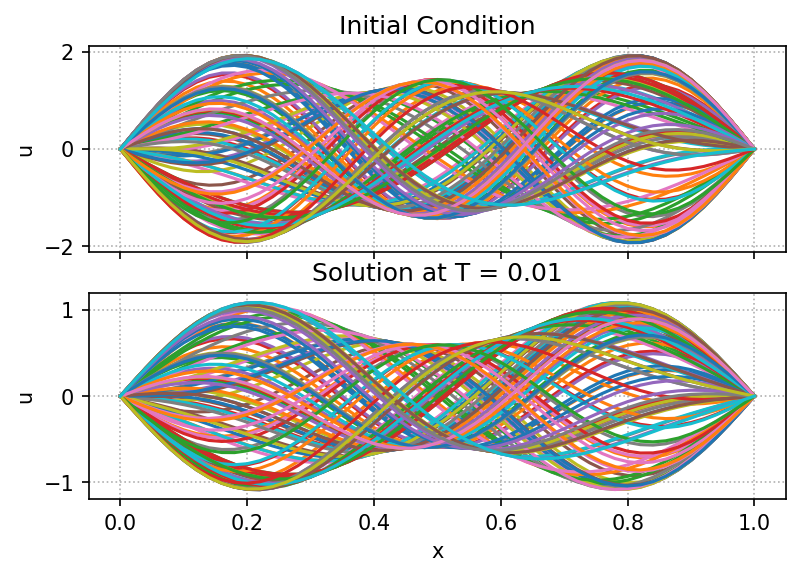

In [3]:
print("###############################")
print("Generating Training Set")
torch.manual_seed(12446)
n_samples = 100
sobol = False
min_inputs = -5
max_inputs = 5
d = 2
# Inputs for generating the training set are in [-5,5]
if not sobol:
    y_rand = torch.rand((n_samples, d))
    y = (max_inputs - min_inputs)*y_rand + min_inputs
else:
    sob_eng = torch.quasirandom.SobolEngine(d)
    sob_eng.fast_forward(1)
    y_sob = sob_eng.draw(n_samples)
    y = (max_inputs - min_inputs)*y_sob + min_inputs
training_set = torch.zeros((n_samples, y.shape[1] + 1))


print("###############################")
fig, axs = plt.subplots(2, dpi=150)
axs[0].grid(True, which="both", ls=":")
axs[1].grid(True, which="both", ls=":")
for j in range(n_samples):
    f, (x, ic, u_end) = solve_heat_eq(y[j])
    training_set[j, :d] = y[j]
    training_set[j, -1] = f
    axs[0].plot(x,ic)
    axs[1].plot(x,u_end)
    
axs[0].set(ylabel='u')
axs[1].set(xlabel='x', ylabel='u')
axs[0].set_title("Initial Condition")
axs[1].set_title("Solution at T = 0.01")
for ax in fig.get_axes():
    ax.label_outer()


Final Training loss:  7.265030035341624e-07


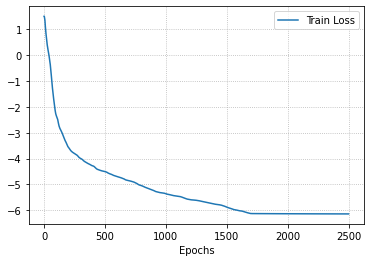

In [4]:
if not sobol:
    inputs = y_rand
else:
    inputs = y_sob
output = training_set[:, -1].reshape(-1, 1)

batch_size = inputs.shape[0]
training_set_loader = DataLoader(torch.utils.data.TensorDataset(inputs, output), batch_size=batch_size, shuffle=True)

model = NeuralNet(input_dimension=inputs.shape[1], 
                  output_dimension=output.shape[1], 
                  n_hidden_layers=4, 
                  neurons=20, 
                  regularization_param=0.0, 
                  regularization_exp=2,
                  retrain_seed=128)


optimizer_ = optim.LBFGS(model.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)

n_epochs = 2500
history = fit(model, training_set_loader, n_epochs, optimizer_, p=2, verbose=False)
print("Final Training loss: ", history[-1])

plt.figure()
plt.grid(True, which="both", ls=":")
plt.plot(np.arange(1, n_epochs + 1), np.log10(history), label="Train Loss")
plt.xlabel("Epochs")
plt.legend()

In [5]:
def generate_test_set(n_samples):
    torch.manual_seed(34)
    inputs_ = (max_inputs - min_inputs)*torch.rand((n_samples, d)) + min_inputs
    s_ = torch.zeros((n_samples, d + 1))

    print("###############################")
    print("Generating Test Set")
    for j in range(n_samples):
        s_[j, :d] = inputs_[j]
        s_[j, -1], _ = solve_heat_eq(inputs_[j])

    return s_



test_set = generate_test_set(10000)





###############################
Generating Test Set


In [6]:
test_inputs = test_set[:, :d]
test_output = test_set[:, -1]

test_inputs_scaled = (test_inputs - min_inputs)/(max_inputs - min_inputs)

test_pred = model(test_inputs_scaled).reshape(-1, ) 
err = (torch.mean((test_output - test_pred) ** 2) / torch.mean(test_output ** 2)) ** 0.5

print("Error Model : ", err.item())

Error Model :  0.025952287018299103


Text(0.5, 1.0, 'Approximate Solution')

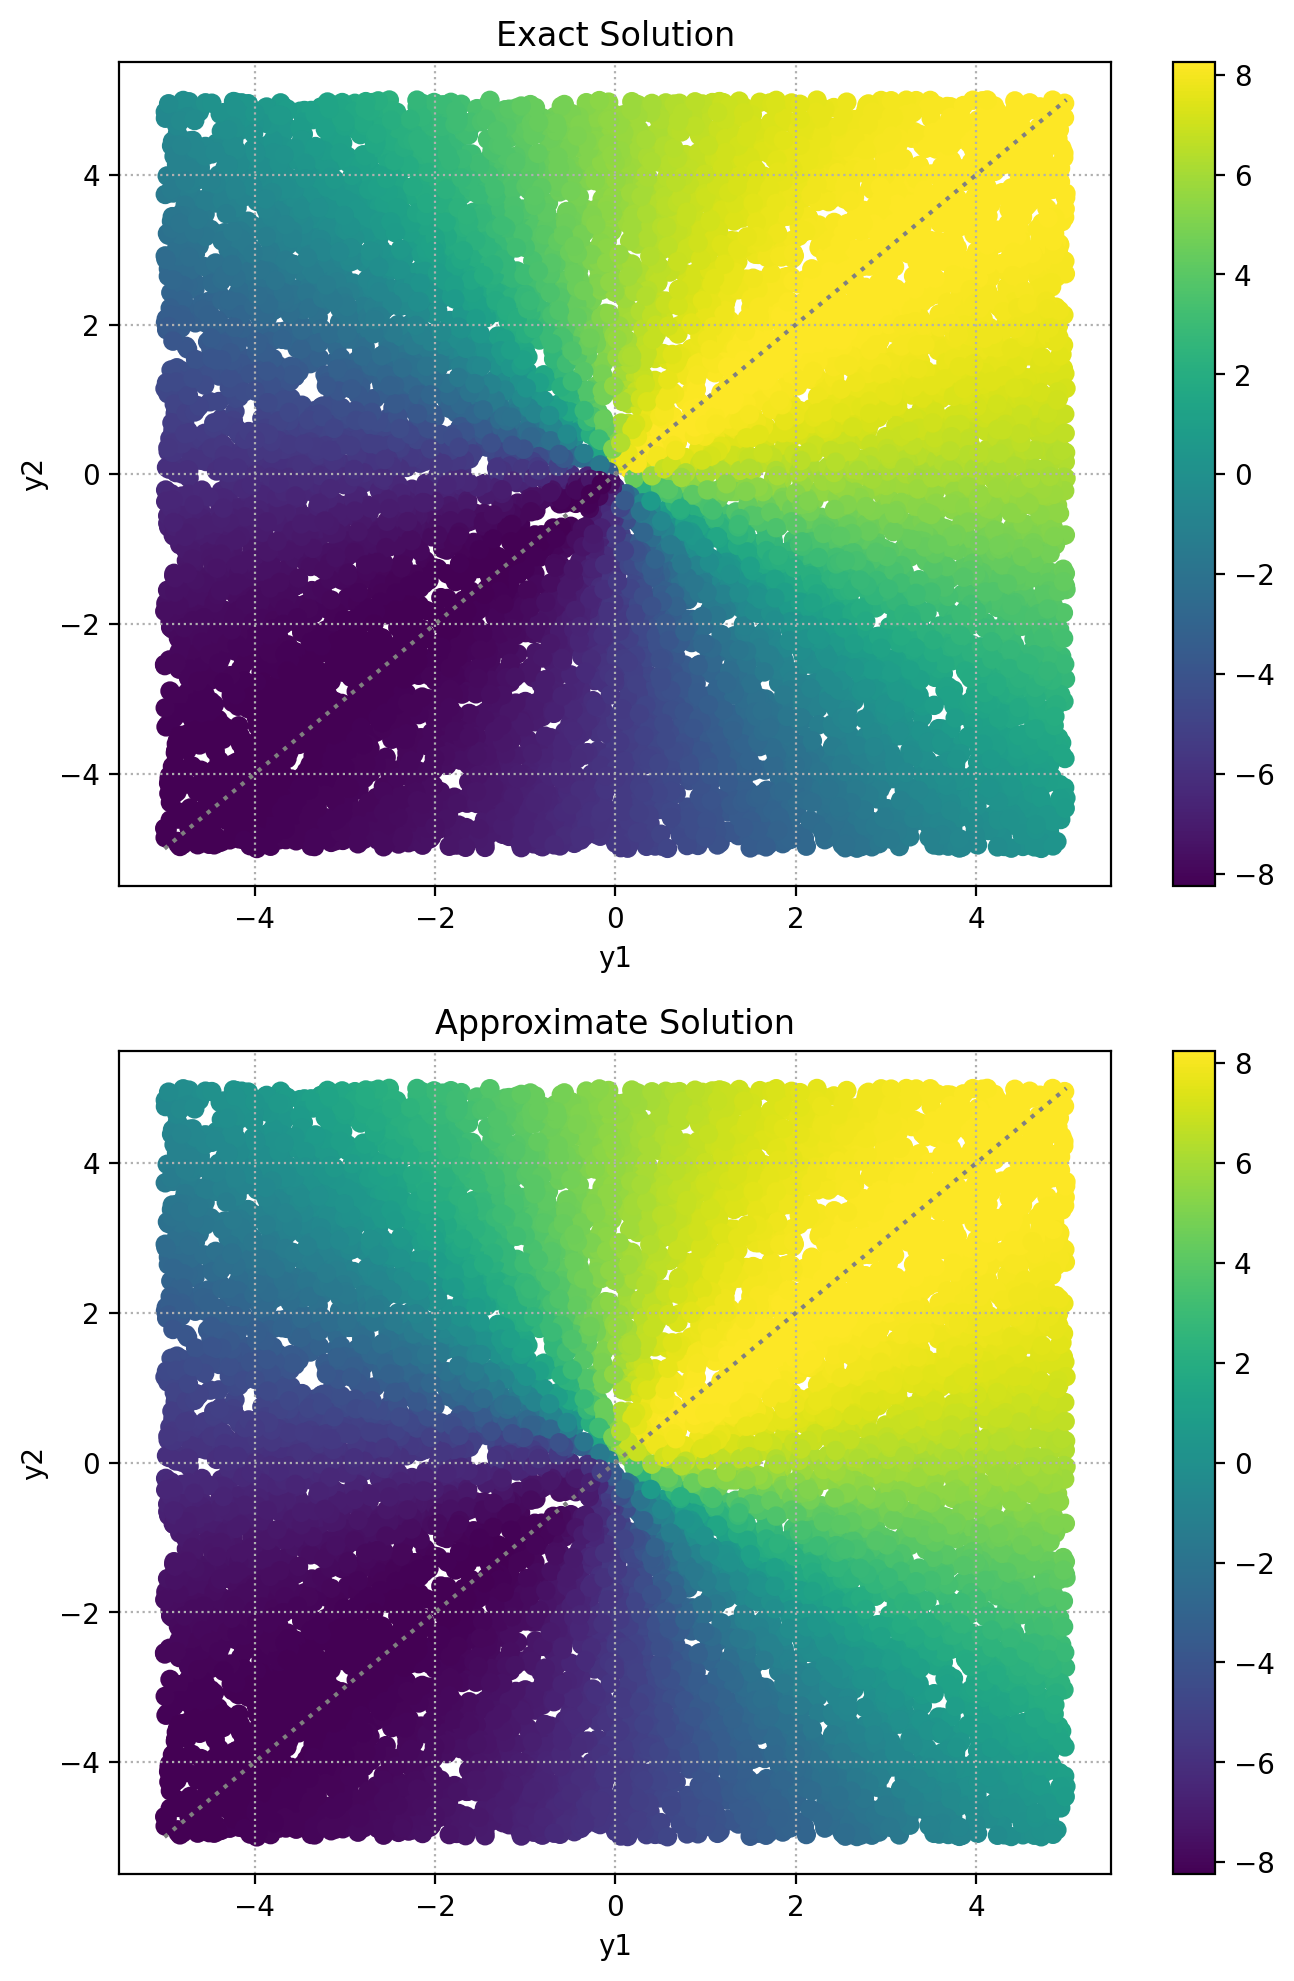

In [14]:
y1=torch.linspace(-5,5, 10000)
fig, axs = plt.subplots(2, figsize=(8,12), dpi=200)
im1 = axs[0].scatter(test_inputs[:,0], test_inputs[:,1], c=test_output)
axs[0].set_xlabel("y1")
axs[0].set_ylabel("y2")
plt.colorbar(im1,ax=axs[0])
axs[0].plot(y1,y1, color="grey", ls=":")
axs[0].grid(True, which="both", ls=":")
im2 = axs[1].scatter(test_inputs[:,0], test_inputs[:,1], c=test_pred.detach())
axs[1].set_xlabel("y1")
axs[1].set_ylabel("y2")
plt.colorbar(im2,ax=axs[1])
axs[1].plot(y1,y1, color="grey", ls=":")
axs[1].grid(True, which="both", ls=":")
axs[0].set_title("Exact Solution")
axs[1].set_title("Approximate Solution")





## Uncertainty Quantification

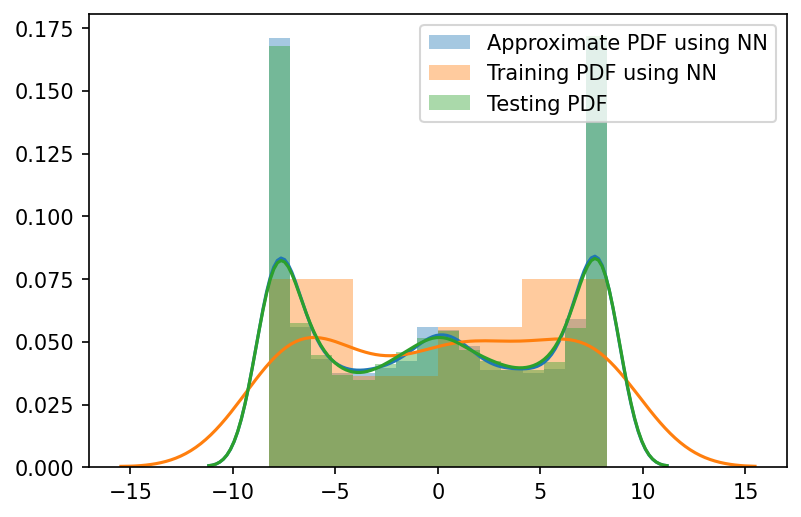

In [8]:
inputs_for_UQ = torch.rand((10000, 2))
outputs_for_UQ = model(inputs_for_UQ).reshape(-1,).detach()

plt.figure(dpi=150)
sb.distplot(outputs_for_UQ, label="Approximate PDF using NN")
sb.distplot(output, label="Training PDF using NN")
sb.distplot(test_output, label="Testing PDF ")
plt.legend()

## Optimal Design

We want to find a value of the input variables $y$ that maximizes the flux $q$:
$$
y_{opt, exact} = \arg\max_{y\in[0,1]^d} q(y)
$$

In order to solve the problem we employ the DNNOPT algorithm, that boils down to replacing the model $q(y)$ with the neural network previously trained $q^*(y)$ and solving the maximization problem:
$$
y_{opt} = \arg\max_{y\in[0,1]^d} q^*(y) 
$$

/Users/mroberto/opt/anaconda3/envs/Pinns/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Minimizer:  tensor([1.0706, 0.9429], grad_fn=<ClampBackward>)
Corresponding flux values:  tensor([8.2426], grad_fn=<AddBackward0>)


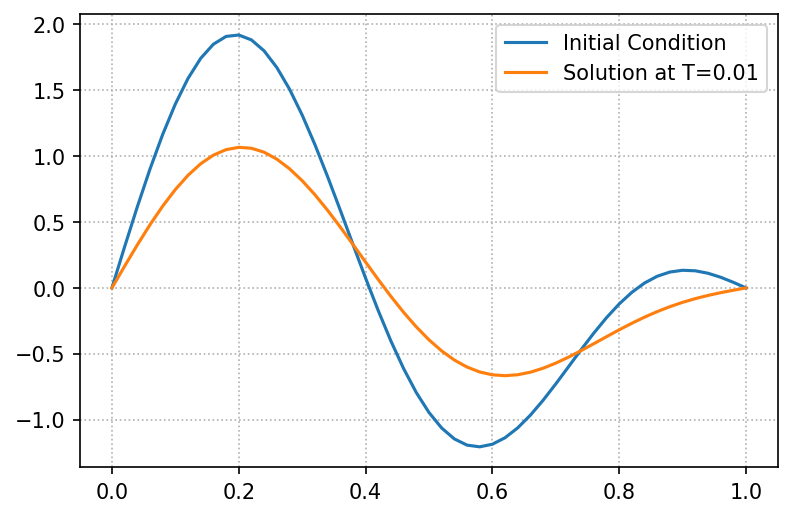

In [9]:
y_opt = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)
y_init = torch.clone(y_opt)

optimizer = optim.LBFGS([y_opt], lr=float(0.00001), max_iter=50000, max_eval=50000, history_size=100, line_search_fn="strong_wolfe", tolerance_change=1.0 * np.finfo(float).eps)

optimizer.zero_grad()
cost = list([0])


def closure():
    
    G = -model((torch.clamp(y_opt, min=min_inputs, max=max_inputs)-min_inputs)/(max_inputs - min_inputs))
    cost[0] = G
    G.backward()
    return G


optimizer.step(closure=closure)
print("Minimizer: ", torch.clamp(y_opt, min=min_inputs, max=max_inputs))
print("Corresponding flux values: ", model((torch.clamp(y_opt, min=min_inputs, max=max_inputs)-min_inputs)/(max_inputs - min_inputs)))

f_opt, (x,ic,u) = solve_heat_eq(torch.clamp(y_opt, min=min_inputs, max=max_inputs))
plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(x, ic.detach(),label="Initial Condition")
plt.plot(x, u.detach(), label="Solution at T=0.01")
plt.legend()


/Users/mroberto/opt/anaconda3/envs/Pinns/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


Exact Minimizer:  tensor([1.0586, 0.9734], grad_fn=<ClampBackward>)


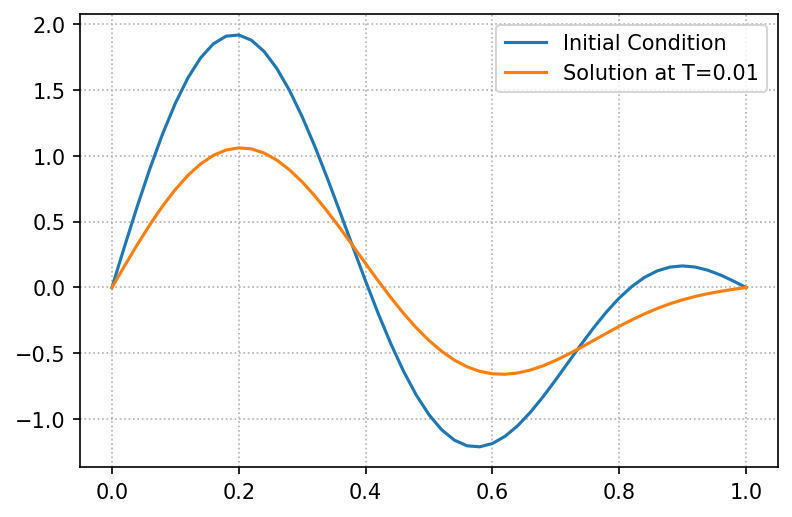

In [10]:
y_opt_ex = torch.tensor(torch.tensor([0.5, 1.24]), requires_grad=True)
y_init = torch.clone(y_opt_ex)

optimizer = optim.LBFGS([y_opt_ex], lr=float(0.00001), max_iter=50000, max_eval=50000, history_size=100, line_search_fn="strong_wolfe", tolerance_change=1.0 * np.finfo(float).eps)

optimizer.zero_grad()
cost = list([0])


def closure():
    G, _ = solve_heat_eq(torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))
    G = -G
    cost[0] = G
    G.backward()
    return G


optimizer.step(closure=closure)
print("Exact Minimizer: ", torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))

f_opt_ex, (x,ic,u) = solve_heat_eq(torch.clamp(y_opt_ex, min=min_inputs, max=max_inputs))

plt.figure(dpi=150)
plt.grid(True, which="both", ls=":")
plt.plot(x, ic.detach(),label="Initial Condition")
plt.plot(x, u.detach(), label="Solution at T=0.01")
plt.legend()



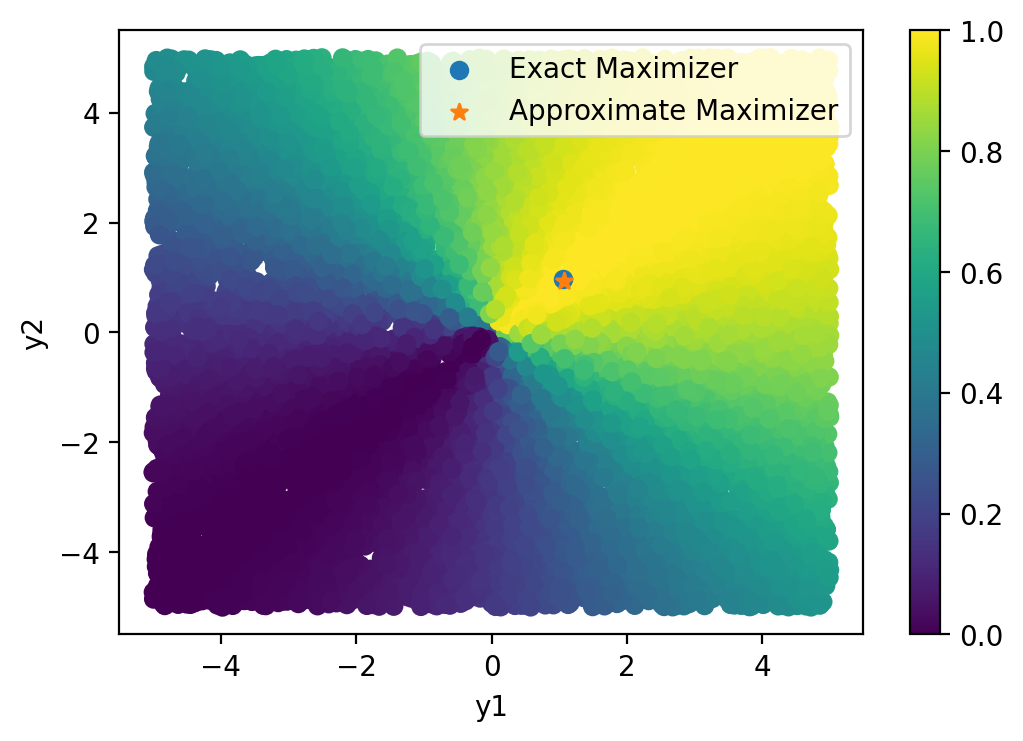

In [16]:
plt.figure(dpi=200)
plt.scatter(test_inputs[:,0], test_inputs[:,1], c=test_output)
plt.scatter(y_opt_ex[0].detach(), y_opt_ex[1].detach(), marker = "o", label = "Exact Maximizer")
plt.scatter(y_opt[0].detach(), y_opt[1].detach(), marker = "*", label = "Approximate Maximizer")
plt.colorbar()
plt.xlabel("y1")
plt.ylabel("y2")
plt.legend()